# Task03 基础实战（FashionMNIST时装分类）

## 1 导入包

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## 2 配置训练环境和超参数

In [2]:
# 使用GPU环境
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [3]:
# 配置其他超参数
batch_size = 256
# 在Windows环境下，需要将num_workers改为0，否则会存在多线程问题
num_workers = 0
lr = 1e-4
epochs = 20

## 3 数据读取和加载

In [4]:
from torchvision import transforms

# 设置数据变换
image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [5]:
# 自定义数据集
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [6]:
train_df = pd.read_csv("./FashionMNIST/fashion-mnist_train.csv")
test_df = pd.read_csv("./FashionMNIST/fashion-mnist_test.csv")

In [8]:
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

In [9]:
# 使用DataLoader类加载数据
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([256, 1, 28, 28]) torch.Size([256])


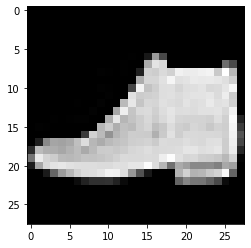

In [10]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

## 4 模型设计

In [11]:
# 使用CNN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

In [12]:
model = Net()
model = model.cuda()

## 5 设置损失函数和优化器

In [13]:
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

In [14]:
# 使用Adam优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 6 训练和验证

In [15]:
def train(epoch):
    # 设置训练状态
    model.train()
    train_loss = 0
    # 循环读取DataLoader中的全部数据
    for data, label in train_loader:
        # 将数据放到GPU用于后续计算
        data, label = data.cuda(), label.cuda()
        # 将优化器的梯度清0
        optimizer.zero_grad()
        # 将数据输入给模型
        output = model(data)
        # 设置损失函数
        loss = criterion(output, label)
        # 将loss反向传播给网络
        loss.backward()
        # 使用优化器更新模型参数
        optimizer.step()
        # 累加训练损失
        train_loss += loss.item() * data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [16]:
def val(epoch): 
    # 设置验证状态
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    # 不设置梯度
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    # 计算验证集的平均损失
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    # 计算准确率
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [17]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

E:\LearningDisk\Learning_Projects\MyPythonProjects\my-team-learning\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.664049
Epoch: 1 	Validation Loss: 0.421500, Accuracy: 0.852400
Epoch: 2 	Training Loss: 0.417311
Epoch: 2 	Validation Loss: 0.349790, Accuracy: 0.871200
Epoch: 3 	Training Loss: 0.355448
Epoch: 3 	Validation Loss: 0.318987, Accuracy: 0.879500
Epoch: 4 	Training Loss: 0.323644
Epoch: 4 	Validation Loss: 0.290521, Accuracy: 0.893800
Epoch: 5 	Training Loss: 0.301900
Epoch: 5 	Validation Loss: 0.266420, Accuracy: 0.901300
Epoch: 6 	Training Loss: 0.286696
Epoch: 6 	Validation Loss: 0.246448, Accuracy: 0.909700
Epoch: 7 	Training Loss: 0.271441
Epoch: 7 	Validation Loss: 0.241845, Accuracy: 0.911200
Epoch: 8 	Training Loss: 0.260185
Epoch: 8 	Validation Loss: 0.243311, Accuracy: 0.910800
Epoch: 9 	Training Loss: 0.247986
Epoch: 9 	Validation Loss: 0.225896, Accuracy: 0.916200
Epoch: 10 	Training Loss: 0.240718
Epoch: 10 	Validation Loss: 0.227848, Accuracy: 0.914700
Epoch: 11 	Training Loss: 0.232358
Epoch: 11 	Validation Loss: 0.220180, Accuracy: 0.917500
Epoch:

## 7 模型保存

In [18]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)